# RNNs

By Charles Patterson

## Business Understanding

This dataset contains a list of tweets with a username and an identified sentiment as either positive (1) or negative (0).  The purpose of this dataset is to correctly identify the sentiment of the user based on the text of the tweet and label accordingly.  This way, if you're an advertiser, you can advertise to people based on their mood.

## Splitting the Data

This dataset had some preproccessing work done on it before I began.  Furthermore, the data had already been split 90/10 train/test respectivily with near perfect balancing.  Since the dataset had over 1M observations, I decided the stratified shuffle split done was appropriate, but I wanted to have an 80/20 split, so I plan to concatante the data and take a stratified shuffle split.

## Choosing a Metric

Since this business case use is to identify the sentiment to its best capability, and the benefit of knowing when someone is in a good mood can be just as important as predicting when they are in a bad mood, I beleive accuracy is a fair metric for this dataset.

## Preparation

In [1]:
import pandas as pd
import numpy as np
X = pd.read_csv("PA01Files/dev-test-data.csv")
y = pd.read_csv("PA01Files/dev-test-target.csv")
X.drop(["Unnamed: 0", "id", "user"], axis = 1, inplace = True)
y.drop(["Unnamed: 0", "id"], axis = 1, inplace = True)
X = np.array(X)
y = np.array(y)
for i in range(len(y)):
    if y[i]==4:
        y[i] = 1

In [2]:
%%time 
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

NUM_TOP_WORDS = None
MAX_ART_LEN = 1000 # maximum and minimum number of words

tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(X.ravel())
sequences = tokenizer.texts_to_sequences(X.ravel())

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

y_ohe = keras.utils.to_categorical(y)

print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y.shape)
print(np.max(X))

Using TensorFlow backend.
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py

Found 128082 unique tokens. Distilled to 128082 top words.
Shape of data tensor: (144000, 1000)
Shape of label tensor: (144000, 1)
128082
CPU times: user 7.33 s, sys: 821 ms, total: 8.16 s
Wall time: 9.14 s


## Tokenization

For my tokenization I implemented it in keras simply because I had the model from class to follow.  I used the inclass assignment of 1000 words max, but given that each of my documents are tweets, thus less than 280 characters, putting a cap on the number of words at 1000 will be of any affect.

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_ohe, test_size=0.2, stratify=y_ohe)
print(X_train.shape,y_train.shape)

(115200, 1000) (115200, 2)


# Modeling

In [4]:
%%time
EMBED_SIZE = 100
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('GloVe Embedding/Glove.6B.100d.txt')
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

Found 400000 word vectors.
(128083, 100)
CPU times: user 13.5 s, sys: 993 ms, total: 14.5 s
Wall time: 15.1 s


In [5]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],
                            input_length=MAX_ART_LEN,
                            trainable=False)

## LSTM

In [6]:
from keras.models import Sequential, Input, Model
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import RMSprop

lstm = Sequential()
lstm.add(embedding_layer)
lstm.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
lstm.add(Dense(2, activation='sigmoid'))
opt = RMSprop(clipnorm=1.0)
lstm.compile(loss='binary_crossentropy', 
              optimizer=opt, 
              metrics=['accuracy'])
print(lstm.summary())

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         12808300  
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 12,888,902
Trainable params: 80,602
Non-trainable params: 12,808,300
_________________________________________________________________
None


In [7]:
historyLSTM = lstm.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_test, y_test))
lstm.save("lstm.h5")

Instructions for updating:
Use tf.cast instead.
Train on 115200 samples, validate on 28800 samples
Epoch 1/3
115200/115200 [==============================] - 2469s 21ms/step - loss: 0.5796 - accuracy: 0.6894 - val_loss: 0.5174 - val_accuracy: 0.7430
Epoch 2/3
115200/115200 [==============================] - 2551s 22ms/step - loss: 0.5280 - accuracy: 0.7334 - val_loss: 0.4894 - val_accuracy: 0.7657
Epoch 3/3
115200/115200 [==============================] - 2496s 22ms/step - loss: 0.5115 - accuracy: 0.7452 - val_loss: 0.4755 - val_accuracy: 0.7729


## 2 Chains

In [8]:
from keras.models import Sequential, Input, Model
from keras.layers import Dense
from keras.layers import LSTM

rnn = Sequential()
rnn.add(embedding_layer)
rnn.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
rnn.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2))
rnn.add(Dense(2, activation='sigmoid'))
rnn.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
print(rnn.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         12808300  
_________________________________________________________________
lstm_2 (LSTM)                (None, 1000, 100)         80400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 12,969,302
Trainable params: 161,002
Non-trainable params: 12,808,300
_________________________________________________________________
None


In [9]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],
                            input_length=MAX_ART_LEN,
                            trainable=False)

In [10]:
historyRNN = rnn.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_test, y_test))
rnn.save("rnn.h5")

Train on 115200 samples, validate on 28800 samples
Epoch 1/3
115200/115200 [==============================] - 5245s 46ms/step - loss: 0.5687 - accuracy: 0.6987 - val_loss: 0.5103 - val_accuracy: 0.7514
Epoch 2/3
115200/115200 [==============================] - 4780s 41ms/step - loss: 0.5126 - accuracy: 0.7459 - val_loss: 0.4811 - val_accuracy: 0.7682
Epoch 3/3
115200/115200 [==============================] - 4712s 41ms/step - loss: 0.4901 - accuracy: 0.7620 - val_loss: 0.4875 - val_accuracy: 0.7561


## Visualize and Compare Preformance

## LSTM

Text(0.5, 0, 'epochs')

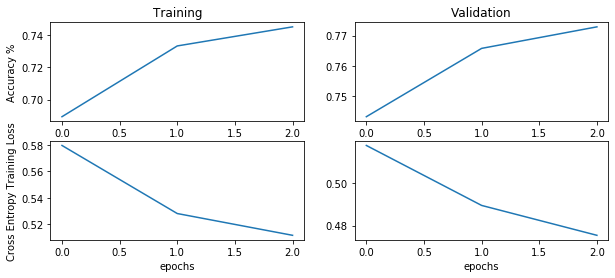

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))

plt.subplot(2,2,1)
plt.plot(historyLSTM.history['accuracy'])
plt.ylabel('Accuracy %')
plt.title('Training')

plt.subplot(2,2,2)
plt.plot(historyLSTM.history['val_accuracy'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(historyLSTM.history['loss'])
plt.ylabel('Cross Entropy Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(historyLSTM.history['val_loss'])
plt.xlabel('epochs')

## 2 Chains

Text(0.5, 0, 'epochs')

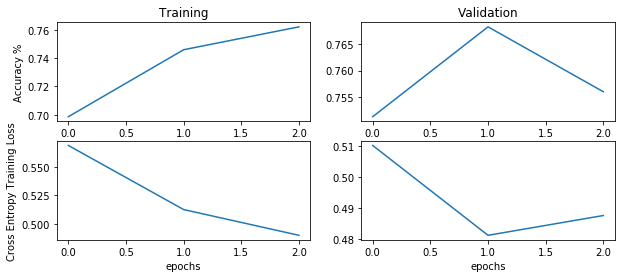

In [17]:
plt.figure(figsize=(10,4))

plt.subplot(2,2,1)
plt.plot(historyRNN.history['accuracy'])
plt.ylabel('Accuracy %')
plt.title('Training')

plt.subplot(2,2,2)
plt.plot(historyRNN.history['val_accuracy'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(historyRNN.history['loss'])
plt.ylabel('Cross Entropy Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(historyRNN.history['val_loss'])
plt.xlabel('epochs')

## Compare

In [18]:
from statsmodels.stats.contingency_tables import mcnemar
def mcnemarTest(table):
    result = mcnemar(table, exact=True)
    print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))
    alpha = 0.05
    if result.pvalue > alpha:
        print('Same proportions of errors (fail to reject H0)')
    else:
        print('Different proportions of errors (reject H0)')

In [23]:
def transform(pred):
    l = len(pred)
    for i in range(l):
        pred[np.argmax(pred[i])] = 1
        pred[i] = np.round(pred[i])
    return pred
yhat_LSTM = lstm.predict(X_test)
yhat_RNN = rnn.predict(X_test)

In [24]:
A = B = C = D = 0
yhat_LSTM = np.array(yhat_LSTM)
yhat_RNN = np.array(yhat_RNN)
y_test = np.array(y_test) 
for i in range(len(yhat_LSTM)):
    if (np.array_equal(yhat_LSTM[i], y_test[i])):
        if np.array_equal(yhat_RNN[i], y_test[i]):
            A += 1
        else:
            B += 1
    else:
        if np.array_equal(yhat_RNN[i], y_test[i]):
            C += 1
        else:
            D += 1

table = [[A,B], [C,D]]
mcnemarTest(table)

statistic=0.000, p-value=1.000
Same proportions of errors (fail to reject H0)


At a significance level of 0.05 and a p-value of 1.  There is not sufficient evidence to conclude that the LSTM model with two chain preforms better than that of the LSTM with one chain.

In [25]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

y_pred_lstm = np.argmax(lstm.predict(X_test), axis=1)

#false positve and true postive rates using roc
fpr_lstm, tpr_lstm, thresholds_lstm = roc_curve(np.argmax(y_test,axis=1), y_pred_lstm)

#area under the curve
auc_lstm = auc(fpr_lstm, tpr_lstm)

y_pred_rnn = np.argmax(rnn.predict(X_test), axis=1)

#false positve and true postive rates using roc
fpr_rnn, tpr_rnn, thresholds_rnn = roc_curve(np.argmax(y_test,axis=1), y_pred_rnn)

#area under the curve
auc_rnn = auc(fpr_rnn, tpr_rnn)

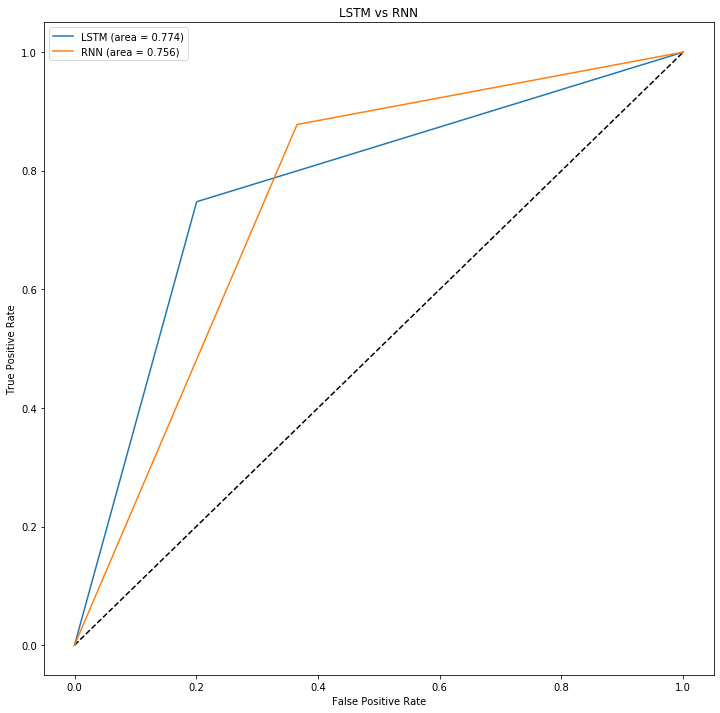

In [28]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(12,12))

#plot halfway line
plt.plot([0,1], [0,1], 'k--')

#plot model 1 ROC
plt.plot(fpr_lstm, tpr_lstm, label='LSTM (area = {:.3f})'.format(auc_lstm))

#plot model 2 ROC
plt.plot(fpr_rnn, tpr_rnn, label='RNN (area = {:.3f})'.format(auc_rnn))


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LSTM vs RNN')
plt.legend(loc='best')
plt.show()

From the graph above, we can see that the RNN with two chains is more accurate than the RNN with out an additional chain.